## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 13, 10

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
calib_images = glob.glob('./camera_cal/calibration*.jpg')
calib_images[:3]

['./camera_cal/calibration5.jpg',
 './camera_cal/calibration4.jpg',
 './camera_cal/calibration6.jpg']

In [3]:
DISPLAY_CHESSBOARD = False


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in calib_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    #print('ret:', ret)
    
    # If found, add object points, image points
    if ret is True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        if DISPLAY_CHESSBOARD:
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

cv2.destroyAllWindows()

In [4]:
print("The chessboard was found on {} out of {} calibration images.".format(len(imgpoints), len(calib_images)))

The chessboard was found on 17 out of 20 calibration images.


In [5]:
#Camera calibration matrices
img_ = cv2.imread(calib_images[0])
img_size = img.shape[1], img.shape[0]
%xdel img_
print("img_size:", img_size)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

img_size: (1280, 720)


###  Examples of undistorted calibration images

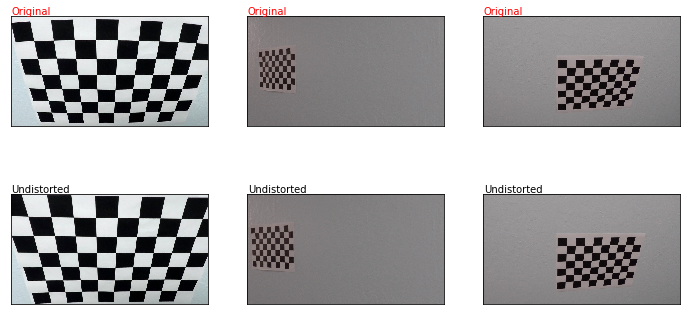

In [6]:
N_IMGS = 3
ls_imgs = np.random.choice(np.arange(len(calib_images)), size = N_IMGS, replace=False)

NR = 2 #number of rows for display : one for the normal images, one for the flipped versions
_, ax = plt.subplots(NR, N_IMGS, figsize=(12, 6))
col, row = 0, 0

for col, idx in enumerate(ls_imgs): 
    img = cv2.imread(calib_images[idx])
    img2 = cv2.undistort(img, mtx, dist, None, mtx)
    
    ax[0, col].imshow(img)
    ax[0, col].text(3, -5, 'Original', fontsize=10, color='red')
    ax[0, col].get_xaxis().set_visible(False)
    ax[0, col].get_yaxis().set_visible(False)

    ax[1, col].imshow(img2)
    ax[1, col].text(4, -5, 'Undistorted', fontsize=10, color='black')
    ax[1, col].get_xaxis().set_visible(False)
    ax[1, col].get_yaxis().set_visible(False)

plt.show()

###  Examples of undistorted test images

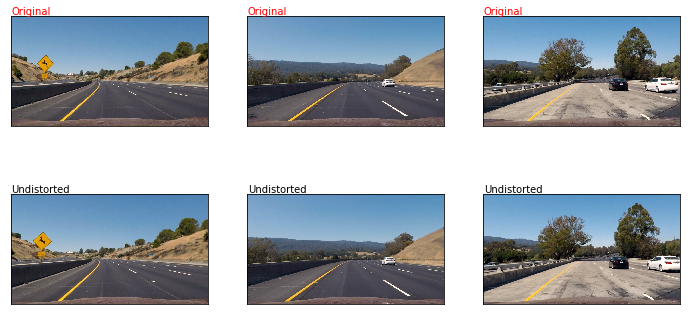

In [7]:
N_IMGS = 3

test_images = glob.glob('./test_images/*.jpg')
ls_imgs = np.random.choice(np.arange(len(test_images)), size = N_IMGS, replace=False)

NR = 2 #number of rows for display : one for the normal images, one for the flipped versions
_, ax = plt.subplots(NR, N_IMGS, figsize=(12, 6))
col, row = 0, 0

for col, idx in enumerate(ls_imgs): 
    img = cv2.imread(test_images[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2 = cv2.undistort(img, mtx, dist, None, mtx)
    
    ax[0, col].imshow(img)
    ax[0, col].text(3, -5, 'Original', fontsize=10, color='red')
    ax[0, col].get_xaxis().set_visible(False)
    ax[0, col].get_yaxis().set_visible(False)

    ax[1, col].imshow(img2)
    ax[1, col].text(4, -5, 'Undistorted', fontsize=10, color='black')
    ax[1, col].get_xaxis().set_visible(False)
    ax[1, col].get_yaxis().set_visible(False)
    
plt.show()

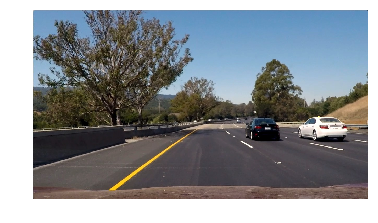

In [8]:
# we read an image
##interesting ones: 4
INDEX = 0

image = cv2.imread(test_images[INDEX])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image) 
plt.axis('off');

In [9]:
#helpers

undistort_image = lambda img: cv2.undistort(img, mtx, dist, None, mtx)

def gaussian_blur(img, kernel=5):
    return cv2.GaussianBlur(img, (kernel,kernel), 0)

## We can see that the original and the undistorted images do not coincide

In [10]:
image_ud = undistort_image(image)

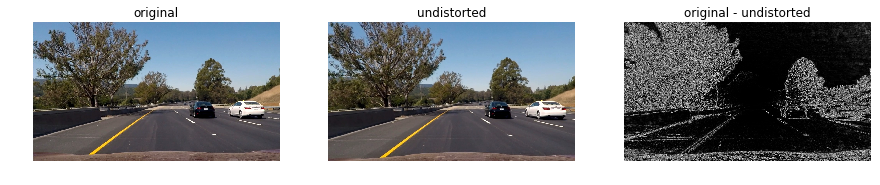

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off');
plt.title('original')

plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2), cmap='gray')
plt.title('original - undistorted')
plt.axis('off');

In [12]:
#We work with the undistorted image from now on
image = image_ud

img_size = image.shape
img_size

(720, 1280, 3)

### We compute the coordinates of points of interest for a trapezoidal shape: top, bottom, center, left center, etc.:


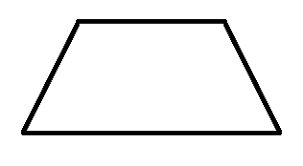

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAS8AAACmCAMAAAC8yPlOAAAAb1BMVEX///8AAACsrKzS0tIUFBQ7Ozv7+/uNjY3FxcXx8fHj4+P4+Pi+vr7CwsL8/PxZWVliYmLb29tpaWl4eHiGhoYwMDCfn59ycnKzs7NMTEympqZCQkLo6OhTU1MfHx+AgIA4ODgYGBgkJCSWlpYrKysMhfWoAAAFD0lEQVR4nO2c7XqiMBCFRaWKqFRbql21fvX+r3HlxD7dVVADSWYG5/2vHCYDCZM56XQURVEURVEURVEURVEURVEURRizqM+PaEYdlipmEU+4BkzjZUePOjAV9KgDU86o0PYV8+KrEDWiDk0pw0LakVrFBcdC1JBaRRkJcn9ALeOCAVQl1DJKmBTC8iW1jAuWeSFrQi3jmhQD+U4t44p36EqpZVyxLGTFY2oZV4zjQhi3tO90MIxv1CpKeIMyahWX/ClErThORMNVIe0PtYwLMIhzahWlzBkmGKbtFc+FdG/Fb6GDIcyoVVSQsUuwLdKL63ftDAm2pZbxDxjAFbWKSlbMEgxv1N2aWkYl6x2v2QjDl1OruEHOKsHwPs35fXL8kuac5qPvQkyfWsVN+oXEb2oVBrxN99Qq7rDnMyNxm31K4TODxxLCdQ5YTK3ixGch5ECt4i6HQuYntYpOZyMjvc4JtqFWkWzYvBjugNfshrqS/yolvc4J9kqrYZ0xEPEgGNqM9qttISe9zgm2oFQwy7hW7ctAJT+jrDqh7hW9ECqw4SUiroP1MDkOxMQLVfMNXdWc72Z7OcQtC0Ms7T84F3L+J/3AIp9q1w+9LxHfsuo1aygm6iEyG6FdOel1SrAu4bYytrTZNjuWY1pGSTa7J6jxLqVMjoYXtMXkFP1NuDLX3tBKTI8tQbvOGCVxfv1L9xhjsyG8blyXZ2foTdBlG36cTbgY9jneZUISsInweAVWPhQbrp+AhX2TyH0cSR5IslnZCcFXQlNc8Vtmep0SDA0My2mwC5qvim6w67mmG/ZLzny1xvLWXj8M46CVAhjRoo9AV/MB6mChbGvEVTcXBK10JpRFN0ccw1XSU+pdAxecd2pCJBhXI5odwWxr0y35rqcLzE7zNkC1EwMjZUu7mlC2NfTaZzwd5DaMkGD+e/KjMJfxTxjbGhYumZwt7WoSJJjvDk0MCpfG/2aEsK3hy34T7sveJ1OswfyaGDAkErpVH8G/cSAK8ciH49N3wFqVXv4TDH+/8/f/wdl5Ddj00J7J0YA3/sHX9IVwfXn6cxpw3JUnM886b8vS/hcs8nM/LX9CjGh24J682NZmiBenUwlcgOpU7KM6JcaIZgfuyoNtjeOpKi7wdZKNICOaHbgv544x0wwtec+xCuwOOm+ZFmVEswN35ti2xvVUOxf4OElQlhHNDg+2NXMqp7xm6MdA85/Tk1ClGdHscG5b6+JLW3KDyW3QjXtw188mz4hmh2PbmmnHk91gchvTj+sqwSQa0exwaltrf7jcBixwdywJDjuYnyFcLgOGx3Hf5rd9QW+PB7L51se49ZOjwUyRjT9hTDP07gnihb3Ixi3Tko1odjixrSVY2n+2P71OCYZuimOzj2TZRjQ7HNjWEhQmxDdDP4ZpmR40STDpRjQ7Gq80E5RV58+RXqfsQHfAtn6CyTei2dHQtpZgU2guv9f+UUZIsEXdBGuDEc2ORrY106C+aG9Z9Zo1nqia9oJ2GNHsaGBbS7FFu5B0HFpzUiRYXOumEWr5RjQ76tvW8EPS03BJqN0ogt+1q1v1Eera1p40XLUDpvGyAj+ScU67a+p0UqZPOTka3mqswfCT9hjR7LC3raEw0X+upf0v733bMgUCvBv1npORtW0NNqQnx8ZYpvGyixe1VhZYxKtLrZUBVrs8XcUmXIqiKIqiKIqiKIqiKIqiKIqiKIqiKIqiKIqiuOAvzYo1Hpr3OMoAAAAASUVORK5CYII=")

In [14]:
ytop = int(img_size[0] * .66)    #top
ybottom = img_size[0]            #bottom

width_div2 = img_size[1]//2     #width divided by 2
xc_window = width_div2          #center


xtopleft = xc_window - .23 * width_div2
xtopright = xc_window + .23 * width_div2

xbottomleft = xc_window - .96 * width_div2
xbottomright = xc_window + .96 * width_div2

### We compute the perspective transform matrix:

In [15]:
src = np.float32([ [xbottomleft, ybottom],
                  [xbottomright, ybottom],
                  [xtopright, ytop],
                  [xtopleft, ytop] ])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

M    = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

Let's perform a perspective transform on a sample image

In [16]:
warped = cv2.warpPerspective(image.copy(), M, (img_size[1],img_size[0]))

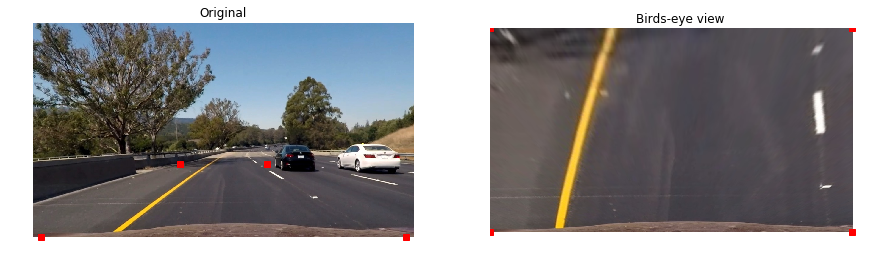

In [17]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(image)
for i in range(4):
    plt.plot(src[i,0], src[i,1],'rs')
plt.title('Original')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(warped)
for i in range(4):
    plt.plot(dst[i,0], dst[i,1],'rs')
    
plt.title('Birds-eye view')
plt.axis('off');

We define a helper with what we saw:

In [18]:
def do_perspective_transform(img):
    
    ALPHA = .23
    BETA = .96
    
    img_size = img.shape
    ytop = int(img_size[0] * .66)    #top
    ybottom = img_size[0]            #bottom

    width_div2 = img_size[1]//2     #width divided by 2
    xc_window = width_div2          #center


    xtopleft = xc_window - ALPHA * width_div2
    xtopright = xc_window + ALPHA * width_div2

    xbottomleft = xc_window - BETA * width_div2
    xbottomright = xc_window + BETA * width_div2
    
    src = np.float32([ [xbottomleft, ybottom],
                  [xbottomright, ybottom],
                  [xtopright, ytop],
                  [xtopleft, ytop] ])

    dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                      [img_size[1],0],[0,0]])

    M    = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img.copy(), M, (img_size[1],img_size[0]))
    
    return warped, M, Minv

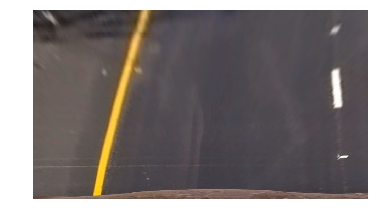

In [19]:
warped, _, _ = do_perspective_transform(image)
plt.imshow(warped) 
plt.axis('off');

## Apply color mask

Next we will apply color masks to identify yellow and white lane markings in the birds-eye view image.

### First, we're going to look for a good yellow mask

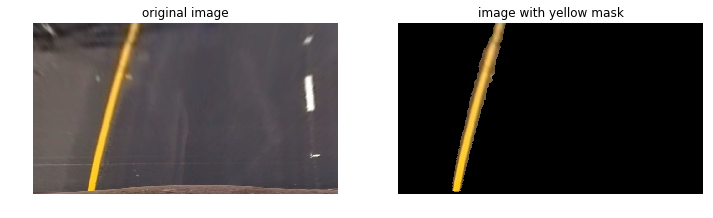

In [20]:
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)

yellow_hsv_low  = np.array([0,  100,  100])
yellow_hsv_high = np.array([90, 255, 255])

yellow_mask = cv2.inRange(image_HSV, yellow_hsv_low, yellow_hsv_high)
res = cv2.bitwise_and(warped, warped, mask=yellow_mask)
#good tuto: https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(res)
plt.title('image with yellow mask')
plt.axis('off');

### Second, we look for a good white mask

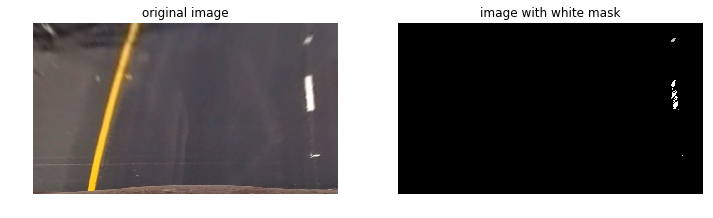

In [21]:
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)

white_hsv_low  = np.array([ 20,   0,   180])
white_hsv_high = np.array([ 255,  80, 255])

white_mask = cv2.inRange(image_HSV, white_hsv_low, white_hsv_high)
res = cv2.bitwise_and(warped, warped, mask=white_mask)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(res)
plt.title('image with white mask')
plt.axis('off');

## Combine color masks
We next combine the yellow and white masks.

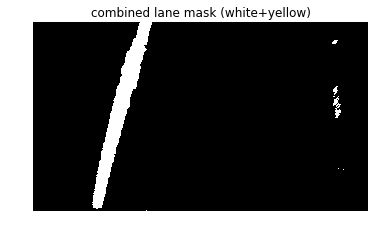

In [22]:
yw_lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

plt.imshow(yw_lane_mask, cmap='gray')
plt.title('combined lane mask (white+yellow)')
plt.axis('off');

In [23]:
yw_lane_mask.max()

255

## Apply Sobel filters

Next we will apply sobel filters to the L and S channels of the image.

We chose L and S channels because in L and S channels, the lanes were more visible.

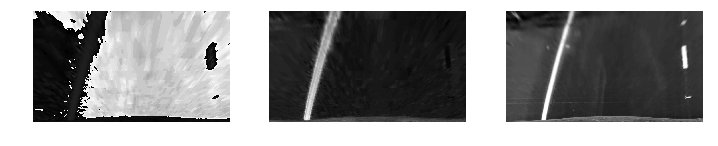

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0], cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1], cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2], cmap='gray')
plt.axis('off');

### We apply sobel filters to L and S channels

In [25]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    assert orient in 'xy'
    
    if orient == 'x':
        img_s = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = np.zeros_like(img_sobel, dtype='uint8')
    #binary_output[thresh[0] <= img_sobel <= thresh[1]] = 1
    binary_output[(img_sobel >= thresh[0]) & (img_sobel <= thresh[1])] = 255
    return binary_output

### Experimentation with L channel

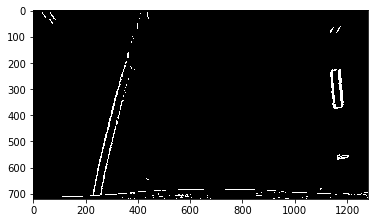

In [26]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,1]


img_abs_x = abs_sobel_thresh(img_gs, 'x', 5, (50,225))
img_abs_y = abs_sobel_thresh(img_gs, 'y', 5, (50,225))

wrapped2 = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))

plt.imshow(wrapped2, cmap='gray');

### Experimentation with S channel

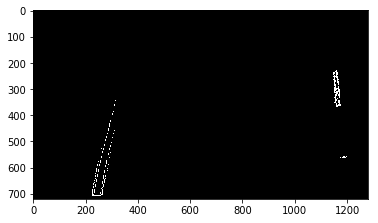

In [27]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)

img_gs = image_HLS[:,:,2]


#img_gs = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
#sobel_c = sobel_combined(img_gs)

img_abs_x = abs_sobel_thresh(img_gs, 'x', 5, (50,225))
img_abs_y = abs_sobel_thresh(img_gs, 'y', 5, (50,225))

wrapped3 = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))

plt.imshow(wrapped3, cmap='gray');

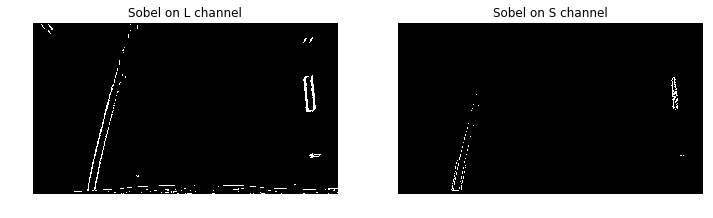

In [28]:
#side by side result

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(wrapped2, cmap='gray')
plt.title('Sobel on L channel')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Sobel on S channel')
plt.imshow(wrapped3, cmap='gray')
plt.axis('off');

### We combine Sobel filters from L and S channels.

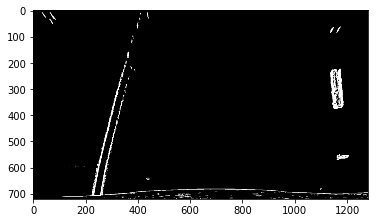

In [29]:
image_cmb = cv2.bitwise_or(wrapped2, wrapped3)

#we add a bit of blur
image_cmb = gaussian_blur(image_cmb, 3)

plt.imshow(image_cmb,cmap='gray')

### We now combine our color masks and sobel filters find the lanes as best as we can

In [30]:
image_cmb_colsob = np.zeros_like(image_cmb)

image_cmb_colsob[(yw_lane_mask == 255) | (image_cmb == 255)] = 1

#We add a bit af gaussian blur
#image_cmb_colsob = gaussian_blur(image_cmb_colsob, 3)

In [31]:
yw_lane_mask.dtype

dtype('uint8')

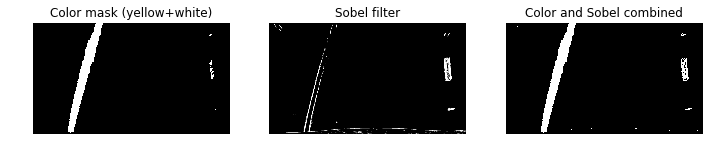

In [32]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.imshow(yw_lane_mask, cmap='gray')
plt.title('Color mask (yellow+white)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image_cmb, cmap='gray')
plt.title('Sobel filter')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(image_cmb_colsob, cmap='gray')
plt.title('Color and Sobel combined')
plt.axis('off');

## Lanes isolation
We will next perform additional analysis to isolate lanes from above. We will take bottom half of the image and compute histogram of distribution of pixel intensities.

In [33]:
mov_filtsize = img_size[1]//50
mov_filtsize

25

In [34]:
#https://stackoverflow.com/a/14314054/3563822
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

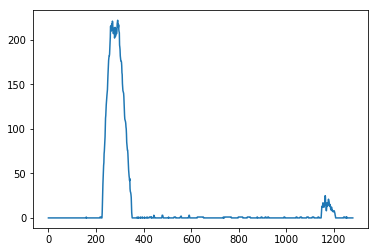

In [35]:
histogram = np.sum(image_cmb_colsob[img_size[0]//2:, :], axis=0)
plt.plot(histogram);

In [36]:
#as shown in the lesson 33
#mean_lane_raw = np.sum(image_cmb_colsob[img_size[0]//2:, :], axis=0)
mean_lane_raw = np.mean(image_cmb_colsob[img_size[0]//2:, :], axis=0)

#we're smoothing mean_lane with a moving average
mean_lane = moving_average(mean_lane_raw, mov_filtsize)

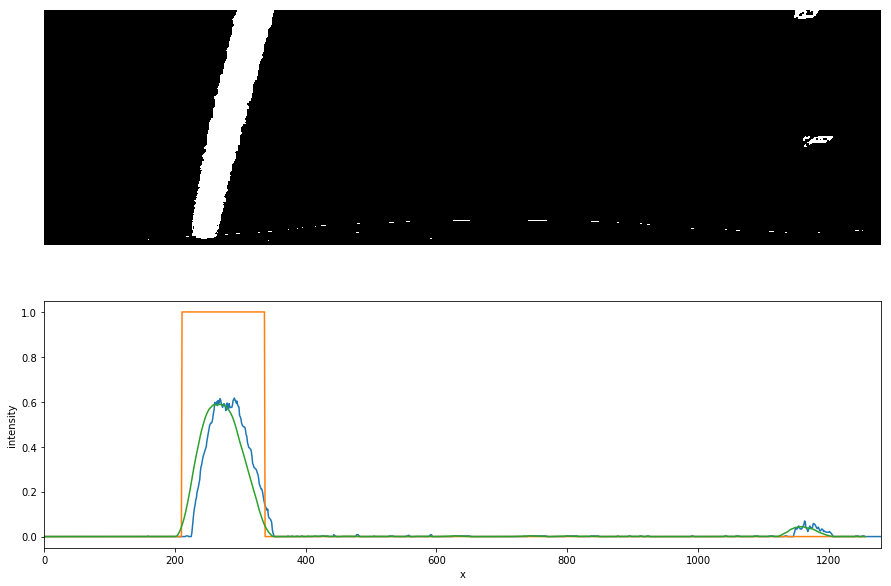

In [37]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.imshow(image_cmb_colsob[img_size[0]//2:, :], cmap='gray')
plt.axis('off')

plt.subplot(2,1,2)
plt.plot(mean_lane_raw)
plt.plot(mean_lane > .05)
plt.plot(mean_lane)
plt.xlabel('x')
plt.ylabel('intensity')
plt.xlim(0,img_size[1]);

copy-pasted from lesson 34

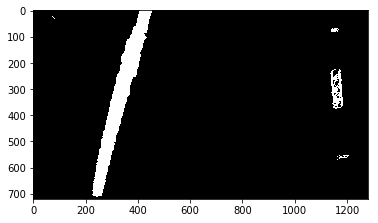

In [38]:
#import matplotlib.image as mpimg

# Read in a thresholded image
#TMP
#warped1 = gaussian_blur(image_cmb_colsob, 11)

open_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
warped2 = cv2.morphologyEx(image_cmb_colsob, cv2.MORPH_OPEN, open_kernel)

warped = warped2

plt.imshow(warped,cmap='gray');

In [39]:
warped.shape, warped2.shape

((720, 1280), (720, 1280))

In [40]:
img_size

(720, 1280, 3)

In [41]:
# window settings
WINDOW_WIDTH = 50
SLIDING_MARGIN = 100 # How much to slide left and right for searching
NB_VERTICAL_LAYERS = 9

window_height = img_size[0]//NB_VERTICAL_LAYERS # Break image into 9 vertical layers since image height is 720

In [42]:
#copy-pasted from lesson 34, then heavily refactored

def find_window_centroids(image, window_width, window_height, margin):
    #hard-coded thresholds for the convolution
    MIN_BASE = 10
    MAX_DIFF = 150
    MIN_CONV = 400
    
    nb_line, nb_col = image.shape
    offset = window_width//2
    WINDOW = np.ones(window_width) # Create our window template that we will use for convolutions

    window_centroids = [] # Store the (left,right) window centroid positions per level

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*nb_line/4):, :nb_col//2], axis=0)
    l_center_base = np.argmax(np.convolve(WINDOW, l_sum)) - offset
    
    ii = np.argmax(np.convolve(WINDOW, l_sum))
    max_conv_left = np.convolve(WINDOW, l_sum)[ii]    
    
    r_sum = np.sum(image[int(3*nb_line/4):, nb_col//2:], axis=0)
    r_center_base = np.argmax(np.convolve(WINDOW, r_sum)) - offset + nb_col//2

    
    ii = np.argmax(np.convolve(WINDOW, r_sum))
    max_conv_right = np.convolve(WINDOW, r_sum)[ii]
    #print("DEBUG: level {}, max_conv: {} | {}".format(0, max_conv_left, max_conv_right))
    #print('conv_signal', conv_signal[l_min_index : l_max_index])    
    
    if not (max_conv_right>MIN_BASE and max_conv_right>MIN_BASE):
        return []
    
    #for the 1st layer, we use these ones
    l_center = l_center_base
    r_center = r_center_base    
    
    # Add what we found for the first layer
    window_centroids.append((l_center, r_center))

    # Go through each layer looking for max pixel locations
    assert window_height == nb_line//NB_VERTICAL_LAYERS
    
    for level in range(1, NB_VERTICAL_LAYERS):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(nb_line-(level+1)*window_height):int(nb_line-level*window_height),\
                                   :], axis=0)
        conv_signal = np.convolve(WINDOW, image_layer)
        
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window,\
        #not center of window
        l_min_index = max(l_center + offset - margin, 0)
        l_max_index = min(l_center + offset + margin, nb_col)
        
        #TODO: we could compare l_center with its previous values and remove outliers
        l_center = np.argmax(conv_signal[l_min_index : l_max_index]) + l_min_index - offset

        #####1
        ii = np.argmax(conv_signal[l_min_index : l_max_index])
        max_conv = conv_signal[l_min_index : l_max_index][ii]
        #print("DEBUG: level {}, max_conv_left {} , dist {}".format(level, max_conv, np.abs(l_center - l_center_base)))
        #print('conv_signal', conv_signal[l_min_index : l_max_index])
        if np.abs(l_center - l_center_base) > MAX_DIFF or max_conv < MIN_CONV:
            l_center = l_center_base
        else:#we keep as ref
            #print('good left one')
            l_center_base = l_center
        #####end1

        # Find the best right centroid by using past right center as a reference
        r_min_index = max(r_center + offset - margin, 0)
        r_max_index = min(r_center + offset + margin, nb_col)
        r_center = np.argmax(conv_signal[r_min_index:r_max_index]) + r_min_index - offset

        #####2
        ii = np.argmax(conv_signal[r_min_index:r_max_index])
        max_conv = conv_signal[r_min_index:r_max_index][ii]
        #print("DEBUG: level {}, max_conv_right {} , dist {}".format(level, max_conv, np.abs(r_center - r_center_base)))
        #print('conv_signal', conv_signal[l_min_index : l_max_index])
        if np.abs(r_center - r_center_base) > MAX_DIFF or max_conv < MIN_CONV:
            r_center = r_center_base
        else:#we keep as ref
            #print('good right one')
            r_center_base = r_center
        #####end2
        #print()
        
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))

    return window_centroids

In [43]:
window_centroids = find_window_centroids(warped, WINDOW_WIDTH, window_height, SLIDING_MARGIN)
window_centroids

[(259, 1181),
 (264, 1181),
 (283, 1181),
 (303, 1181),
 (323, 1160),
 (344, 1156),
 (369, 1156),
 (394, 1156),
 (420, 1156)]

In [44]:
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref, dtype='uint8')
    output[ img_ref.shape[0] - (level+1)*height : img_ref.shape[0]-level*height, \
           max(0, center - width//2) : min(center + width//2, img_ref.shape[1]) ] = 1
    return output

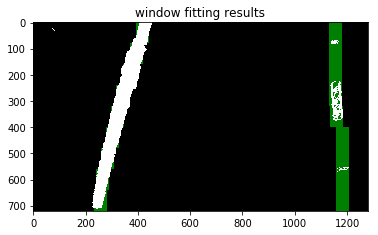

In [45]:
#just for test: we'll deal with the case: window_centroids=[]

# If we found any window centers
if window_centroids:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows
    for level in range(len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_center, r_center = window_centroids[level]
        l_mask = window_mask(WINDOW_WIDTH, window_height, warped, l_center, level)
        r_mask = window_mask(WINDOW_WIDTH, window_height, warped, r_center, level)
        # Add graphic points from window mask here to total pixels found
        l_points = np.bitwise_or(l_points, (l_mask == 1)*255 )
        r_points = np.bitwise_or(r_points, (r_mask == 1)*255 )        

    # Draw the results
    #warning: potential bug: should replace '+' by a bitwise OR
    template = np.uint8(r_points + l_points) # add both left and right window pixels together
    
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.uint8(cv2.merge((zero_channel, template, zero_channel))) # make window pixels green
    
    warpage= np.dstack((warped, warped, warped)) * 255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

# If no window centers found, just display orginal road image
else:
    output = np.uint8(cv2.merge((warped, warped, warped)))


# Display the final results
#plt.figure(figsize=(15,10))
plt.imshow(output)
plt.title('window fitting results')
plt.show()

In [46]:
LANES_FOUND, LANES_NOT_FOUND = "LANES_FOUND", "LANES_NOT_FOUND"
SUCCESS, FAILURE = "SUCCESS", "FAILURE"

In [47]:
def fit_lines_full_search(image, window_width, window_height, margin):
    
    #first we find the centroids
    window_centroids = find_window_centroids(image, window_width, window_height, margin)
    
    if window_centroids:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(image)
        r_points = np.zeros_like(image)

        # Go through each level and draw the windows
        for level in range(len(window_centroids)):
            l_center, r_center = window_centroids[level]
            l_mask = window_mask(WINDOW_WIDTH, window_height, warped, l_center, level)
            r_mask = window_mask(WINDOW_WIDTH, window_height, warped, r_center, level)
            # Add graphic points from window mask here to total pixels found
            l_points = np.bitwise_or(l_points, (l_mask == 1)*255)
            r_points = np.bitwise_or(r_points, (r_mask == 1)*255)        
            
        # Draw the results
        outputLeft = np.bitwise_and(l_points, image)
        outputRight = np.bitwise_and(r_points, image)

        
        # Draw the results
        #warning: potential bug: should replace '+' by a bitwise OR
        template = np.uint8(r_points + l_points) # add both left and right window pixels together

        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.uint8(cv2.merge((zero_channel, template, zero_channel))) # make window pixels green

        warpage= np.dstack((warped, warped, warped)) * 255 # making the original road pixels 3 color channels
        output_full = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

        
        return LANES_FOUND, outputLeft, outputRight, output_full
            
    # If no window centers found, just display orginal road image
    else:
        im = np.uint8(cv2.merge((image, image, image)))
        return LANES_NOT_FOUND, im, im, im

In [48]:
status, outputLeft, outputRight, output_full = fit_lines_full_search(warped, WINDOW_WIDTH, window_height, SLIDING_MARGIN)

In [49]:
#status, outputLeft

status: LANES_FOUND


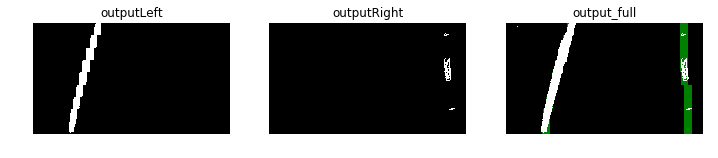

In [50]:
plt.figure(figsize=(12,8))

print("status:", status)

plt.subplot(1,3,1)
plt.imshow(outputLeft, cmap='gray')
plt.title('outputLeft')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(outputRight, cmap='gray')
plt.title('outputRight')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(output_full)
plt.title('output_full')
plt.axis('off');

In [51]:
img_L, img_R = outputLeft, outputRight

In [52]:
img_L.max()

1

In [53]:
vals = np.argwhere(img_L==1)
print(vals[:4,:])
print()
print(vals[-4:,:])

[[  0 408]
 [  0 409]
 [  0 410]
 [  0 411]]

[[710 245]
 [710 246]
 [710 247]
 [710 248]]


In [54]:
vals.shape

(32680, 2)

We split this array so that we get the x and y=f(x) coordinates

In [55]:
vals.T

array([[  0,   0,   0, ..., 710, 710, 710],
       [408, 409, 410, ..., 246, 247, 248]])

In [56]:
x_coords, y_coords = np.split(vals, 2, axis=1)

In [57]:
x_coords, y_coords = x_coords.squeeze(), y_coords.squeeze()
y_coords

array([408, 409, 410, ..., 246, 247, 248])

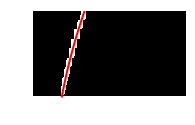

In [58]:
vals = np.argwhere(img_L==1)

x_coords, y_coords = np.split(vals, 2, axis=1)
x_coords, y_coords = x_coords.squeeze(), y_coords.squeeze()

left_fit = np.polyfit(x_coords, y_coords, 2)

#test
left_y = np.arange(11)*img_size[0]/10
left_fitx = left_fit[0]*left_y**2 + left_fit[1]*left_y + left_fit[2]


# Plot up the fake data
plt.subplot(1,2,1)
plt.imshow(img_L, cmap='gray')
plt.plot(left_fitx, left_y, 'red', linewidth=2)
plt.axis('off');

In [59]:
a,b,c = left_fit

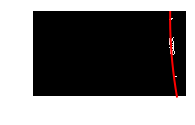

In [60]:
vals = np.argwhere(img_R == 1)

x_coords, y_coords = np.split(vals, 2, axis=1)
x_coords, y_coords = x_coords.squeeze(), y_coords.squeeze()

right_fit = np.polyfit(x_coords, y_coords, 2)

right_y = np.arange(11)*img_size[0]/10
right_fitx = right_fit[0]*right_y**2 + right_fit[1]*right_y + right_fit[2]


# Plot up the fake data
plt.subplot(1,2,2)
plt.imshow(img_R,cmap='gray')
plt.plot( right_fitx, right_y,'r',linewidth=2)
plt.axis('off');

In [61]:
right_fit

array([ 1.29803412e-04, -1.45319602e-02,  1.15254804e+03])

## test curvatures

In [62]:
def get_curvature(y_eval, left_fit, right_fit):
    
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    img_height = 720
    
    #old code
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    center = (((left_fit[0]*img_height**2+left_fit[1]*img_height+left_fit[2]) +(right_fit[0]*img_height**2+right_fit[1]*img_height+right_fit[2]) ) /2 - 640)*xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad, center

In [63]:
for y_eval in (0, 100, 300, 720):
    left_curverad, right_curverad, center = get_curvature(y_eval, left_fit, right_fit)
    print("center: {:.2f} | left/right curvatures at {:>3}: | {:.2f} / {:.2f} | diff: {:.2f}".format(center, y_eval, left_curverad, right_curverad, np.abs(left_curverad - right_curverad)))

center: 0.45 | left/right curvatures at   0: | 5242.04 / 3853.20 | diff: 1388.84
center: 0.45 | left/right curvatures at 100: | 5237.45 / 3853.02 | diff: 1384.43
center: 0.45 | left/right curvatures at 300: | 5228.33 / 3852.71 | diff: 1375.61
center: 0.45 | left/right curvatures at 720: | 5209.34 / 3852.24 | diff: 1357.10


### Finally, draw the lanes back on the original image.

In [64]:
#np.vstack([left_fitx, left_y])

In [65]:
warped.shape == image_cmb_colsob.shape

True

In [66]:
warp_zero = np.zeros_like(warped, dtype='uint8')
color_warp_zero = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
pts = np.hstack((pts_left, pts_right))
pts.shape

(1, 22, 2)

In [67]:
#pts

In [68]:
def add_borders(img, pts, color):
    pts = np.int_(pts)
    for i in range(pts.shape[1]-1):
        x1 = pts[0,i,0]
        y1 = pts[0,i,1]
        x2 = pts[0,i+1,0]
        y2 = pts[0,i+1,1]
        cv2.line(img, (x1, y1), (x2, y2), color, 50)

In [69]:
#we fill a polynom 
color_warp = cv2.fillPoly(color_warp_zero.copy(), np.int_([pts]), (0,255,255))

add_borders(color_warp, np.int_(pts_left), (255,255,0))
add_borders(color_warp, np.int_(pts_right), (255,255,255))

newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

#we blend the track with our real-world picture
result = cv2.addWeighted(image_ud, 1, newwarp, 0.3, 0)

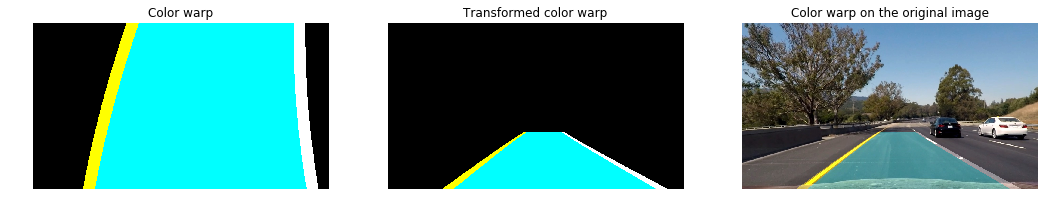

In [70]:
plt.figure(figsize=(18,12))
plt.subplot(1,3,1)
plt.imshow(color_warp)
plt.axis('off')
plt.title('Color warp')

plt.subplot(1,3,2)
plt.imshow(newwarp)
plt.title('Transformed color warp')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(result)
plt.title('Color warp on the original image')
plt.axis('off');

## Global pipeline

In [71]:
# Define a class to receive the characteristics of each line detection
class Line():
    """
    Define the Line class and all the necessary variales to track and record 
    recent and past lines
    """
    def __init__(self, n=5):
        # count of current fit
        self.current_n = 0
        # total number of previous fits to consider
        self.total_n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #corresponding to right-line of image 6
        #self.best_fit = np.array([1.08572350e-05, 1.34752711e-01, 1.02294793e+03])
        
        #polynomial coefficients averaged over the last n iterations
        self.recent_fits = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = dict() 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [72]:
class Pipeline(object):
    
    def __init__(self, image_init=None):
        
        self.counter = 0
        
        self.failed_counter = 0
        self.FAILED_THRESHOLD = 3
        self.do_reset = False
    
        self.left_line_reference = Line(n=5)
        self.right_line_reference = Line(n=5)    

        self.PERC = 0.08 #0.15
        
        self.Y_EVAL = (0, 100, 300, 720)
        
        if image_init is not None:
            self.process(image_init)
            
    def display_internal_state(self):
        print("counter:", self.counter)        
        print("failed_counter:", self.failed_counter)
        print("do_reset:", self.do_reset)
        print("left_line_reference.radius_of_curvature:", self.left_line_reference.radius_of_curvature)      
        print("right_line_reference.radius_of_curvature:", self.right_line_reference.radius_of_curvature) 
        print("left_line_reference.best_fit:", self.left_line_reference.best_fit)      
        print("right_line_reference.best_fit:", self.right_line_reference.best_fit)         
        
    def optical_transform(self, image):
        """
        we transform the image into an image where the left and white lines are clearly visible.
        We use a combination of color and Soble filters.
        
        """
        # 1. Undistort image
        image_ud = undistort_image(image)
        image_ud = gaussian_blur(image_ud, kernel=5)
        img_size = np.shape(image_ud)

        # Define window for perspective transform
        warped, M, Minv_ = do_perspective_transform(image_ud)
    
        #2. we compute good yellow and white masks
        image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)        
        yellow_hsv_low  = np.array([0,  100,  100])
        yellow_hsv_high = np.array([50, 255, 255])
        yellow_mask = cv2.inRange(image_HSV, yellow_hsv_low, yellow_hsv_high)

        white_hsv_low  = np.array([ 20,   0,   180])
        white_hsv_high = np.array([ 255,  80, 255])
        white_mask = cv2.inRange(image_HSV, white_hsv_low, white_hsv_high)

        #we combine them, and get the final yellow+white mask
        yw_lane_mask = cv2.bitwise_or(white_mask, yellow_mask)

        
        #3. we compute Sobel filters
        # Convert image to HLS scheme
        image_HLS = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)

        # Apply sobel filters on L and S channels.
        img_gs = image_HLS[:,:,1]
        img_abs_x = abs_sobel_thresh(img_gs, 'x', 5, (50,225))
        img_abs_y = abs_sobel_thresh(img_gs, 'y', 5, (50,225))
        warped_channel1 = cv2.bitwise_or(img_abs_x, img_abs_y)

        img_gs = image_HLS[:,:,2]
        img_abs_x = abs_sobel_thresh(img_gs, 'x', 5, (50,225))
        img_abs_y = abs_sobel_thresh(img_gs, 'y', 5, (50,225))
        warped_channel2 = np.copy(cv2.bitwise_or(img_abs_x, img_abs_y))

        image_sobel_cmb = cv2.bitwise_or(warped_channel1, warped_channel2)
        #we add a bit of blur
        image_sobel_cmb = gaussian_blur(image_sobel_cmb, 5)


        #4. finally, we combine the color and Sobel steps:
        image_cmb_colsob = np.zeros_like(image_sobel_cmb)
        image_cmb_colsob[(yw_lane_mask == 255) | (image_sobel_cmb == 255)] = 1


        OPEN_KERNEL = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
        warped_final = cv2.morphologyEx(image_cmb_colsob, cv2.MORPH_OPEN, OPEN_KERNEL)

        return image_ud, warped, warped_final

    
    def sanity_check(self, left_fit, right_fit):
        """
        we check the fitted polynoms:
        a. if they are not None
        b. for obvious anomalies
        c. compared to the reference left_line_reference and right_line_reference
        """
        #old
        #MIN_CURV_THRESH = 2000 
        #MAX_CURV_DIFF_THRESH = 200000
        #MAX_CURV_DIFF_WITH_REF_THRESH = 70000 
        
        MIN_CURV_THRESH = 2000 #temp
        MAX_CURV_DIFF_THRESH = 50000 #temp
        MAX_CURV_DIFF_WITH_REF_THRESH = 8000 #10000 #temp        
        
        
        #test: one lane (or both) has not been detected:
        if left_fit is None or right_fit is None:
            return FAILURE

        for y_eval in self.Y_EVAL:
            #step a.
            left_curverad, right_curverad, center = get_curvature(y_eval, left_fit, right_fit)
            if left_curverad < MIN_CURV_THRESH or right_curverad < MIN_CURV_THRESH:
                return FAILURE, left_curverad, right_curverad, center
            if np.abs(left_curverad - right_curverad) > MAX_CURV_DIFF_THRESH:
                return FAILURE, left_curverad, right_curverad, center
            #print("center: {:.2f} | left/right curvatures at {:>3}: | {:.2f} / {:.2f} | diff: {:.2f}".format(center, y_eval, left_curverad, right_curverad, np.abs(left_curverad - right_curverad)))
            
            #step b.
            #if we have no previous data
            left_curverad_ref = self.left_line_reference.radius_of_curvature.get(y_eval, left_curverad)
            right_curverad_ref = self.right_line_reference.radius_of_curvature.get(y_eval, right_curverad)
            
            if np.abs(left_curverad - left_curverad_ref) > MAX_CURV_DIFF_WITH_REF_THRESH:
                print("error left MAX_CURV_DIFF_WITH_REF_THRESH:", np.abs(left_curverad - left_curverad_ref))
                return FAILURE, left_curverad, right_curverad, center
            if np.abs(right_curverad - right_curverad_ref) > MAX_CURV_DIFF_WITH_REF_THRESH:
                print("error right MAX_CURV_DIFF_WITH_REF_THRESH:", np.abs(right_curverad - right_curverad_ref))
                return FAILURE, left_curverad, right_curverad, center
        
        #if we passed every test: sanity check is ok
        
        
        self.Y_EVAL = (0, 100, 300, 720)
        y_eval = self.Y_EVAL[2]
        left_curverad, right_curverad, center = get_curvature(y_eval, left_fit, right_fit)
        
        return SUCCESS, left_curverad, right_curverad, center

    
    def update_lane_refs(self, left_fit, right_fit):
        
        self.left_line_reference.current_fit = left_fit
        self.right_line_reference.current_fit = right_fit
        
        if self.left_line_reference.best_fit is None:
            self.left_line_reference.best_fit = left_fit
        if self.right_line_reference.best_fit is None:
            self.right_line_reference.best_fit = right_fit
            
        self.left_line_reference.best_fit = self.PERC * left_fit + (1-self.PERC) * self.left_line_reference.best_fit
        self.right_line_reference.best_fit = self.PERC * right_fit + (1-self.PERC) * self.right_line_reference.best_fit        
        
        #TODO: we could get them from 'sanity_check' method without recomputing
        for y_eval in self.Y_EVAL:
            left_curverad, right_curverad, center = get_curvature(y_eval, left_fit, right_fit)
            
            self.left_line_reference.radius_of_curvature[y_eval] = left_curverad
            self.right_line_reference.radius_of_curvature[y_eval] = right_curverad        
        
    
    def fit_polynom(self, img):
        """
        we fit a 2-degree polynom on an the non-black points of an image
        """
        vals = np.argwhere(img == 1)
        x_coords, y_coords = np.split(vals, 2, axis=1)
        x_coords, y_coords = x_coords.squeeze(), y_coords.squeeze()
        
        poly = np.polyfit(x_coords, y_coords, 2)
        return poly
        

    def draw_lanes(self, image_ud, warped, left_fitx, left_y, right_fitx, right_y):
        """
        we draw the fitted lines onto the original image
        """
        warp_zero = np.zeros_like(warped, dtype='uint8')
        color_warp_zero = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, left_y]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_y])))])
        pts = np.hstack((pts_left, pts_right))

        #we fill a polynom 
        color_warp = cv2.fillPoly(color_warp_zero.copy(), np.int_([pts]), (0,255,255))

        add_borders(color_warp, np.int_(pts_left), (255,255,0))
        add_borders(color_warp, np.int_(pts_right), (255,255,255))

        new_warp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 

        #we blend the track with our real-world picture      
        result = cv2.addWeighted(image_ud, 1, new_warp, 0.3, 0)
        
        DISPLAY = False
        if DISPLAY:
            plt.figure(figsize=(18,12))
            plt.subplot(1,3,1)
            plt.imshow(color_warp)
            plt.axis('off')
            plt.title('Color warp')

            plt.subplot(1,3,2)
            plt.imshow(new_warp)
            plt.title('Transformed color warp')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.imshow(result)
            plt.title('Color warp on the original image')
            plt.axis('off');
        
        return result

    def fit_lines_full_search(self, image, window_width, window_height, margin):

        #first we find the centroids
        window_centroids = find_window_centroids(image, window_width, window_height, margin)

        if window_centroids:
            # Points used to draw all the left and right windows
            l_points = np.zeros_like(image)
            r_points = np.zeros_like(image)

            # Go through each level and draw the windows
            for level in range(len(window_centroids)):
                l_center, r_center = window_centroids[level]
                l_mask = window_mask(WINDOW_WIDTH, window_height, warped, l_center, level)
                r_mask = window_mask(WINDOW_WIDTH, window_height, warped, r_center, level)
                # Add graphic points from window mask here to total pixels found
                l_points = np.bitwise_or(l_points, (l_mask == 1)*255)
                r_points = np.bitwise_or(r_points, (r_mask == 1)*255)

            # Draw the results
            outputLeft = np.bitwise_and(l_points, image)
            outputRight = np.bitwise_and(r_points, image)

            #warning: potential bug: should replace '+' by a bitwise OR
            template = np.uint8(r_points + l_points) # add both left and right window pixels together

            zero_channel = np.zeros_like(template) # create a zero color channel
            template = np.uint8(cv2.merge((zero_channel, template, zero_channel))) # make window pixels green

            warpage= np.dstack((image, image, image)) * 255 # making the original road pixels 3 color channels
            outputFull = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

            return LANES_FOUND, outputLeft, outputRight, outputFull

        # If no window centers found, just display orginal road image
        else:
            im = np.uint8(cv2.merge((image, image, image)))
            return LANES_NOT_FOUND, im, im, im              

    
    def fit_lines_continuous(self, image, window_width, window_height, margin):

        raise NotImplementedError
    
    
    def process(self, image):
        """
        the full image processing
        """
        image_ud, warped_orig, warped = self.optical_transform(image)
        #image_ud, warped, warped_final
        
        #TMP: remove
        DO_FULL_SEARCH = True 
        
        if DO_FULL_SEARCH or self.counter <=3 or self.do_reset is True:
            status, outputLeft, outputRight, outputFull = self.fit_lines_full_search(warped, WINDOW_WIDTH, window_height, SLIDING_MARGIN)
        else:
            #fast search that uses the stream of previous frames
            status, outputLeft, outputRight, outputFull = self.fit_lines_continuous(warped, WINDOW_WIDTH, window_height, SLIDING_MARGIN)        
        
        assert status in (LANES_FOUND, LANES_NOT_FOUND)
        status_sanity_check, left_curverad, right_curverad, center = -1,-1,-1,-1
        
        if status == LANES_FOUND:
            #step: we fit polynoms
            current_left_fit = self.fit_polynom(outputLeft)
            current_right_fit = self.fit_polynom(outputRight)

            status_sanity_check, left_curverad, right_curverad, center = self.sanity_check(current_left_fit, current_right_fit)
            assert status_sanity_check in (SUCCESS, FAILURE)
            if status_sanity_check == SUCCESS:
                #print("!! sanity-check ok !!")
                self.update_lane_refs(current_left_fit, current_right_fit)
                self.failed_counter = 0
                self.do_reset = False
            else:
                print("sanity-check failed")            
                self.failed_counter +=1
        
        else:#status = LANES_NOT_FOUND
            print("pipeline: lanes not found")           
            self.failed_counter +=1
        
        if self.failed_counter >= self.FAILED_THRESHOLD:
            self.do_reset = True           

        #final step: we draw the fitted lines onto the original image
        a, b, c = self.left_line_reference.best_fit.tolist()
        left_y = np.arange(11)*warped.shape[1]/10
        left_fitx = a*left_y**2 + b*left_y + c
        
        a, b, c = self.right_line_reference.best_fit.tolist()
        right_y = np.arange(11)*warped.shape[1]/10
        right_fitx = a*right_y**2 + b*right_y + c


        result = self.draw_lanes(image_ud, warped, left_fitx, left_y, right_fitx, right_y)
 
        self.counter += 1
    
    
    
        #Composition of images to final display
        img_out = np.zeros((576,1280,3), dtype=np.uint8)

        img_out[0:576,0:1024,:] = cv2.resize(result, (1024,576))
        img_out[0:288,1024:1280, :] = cv2.resize(warped_orig, (256,288))
        img_out[310:576,1024:1280,:] = cv2.resize(outputFull, (256,266))

        
        #Write curvature and center in image
        TextL = "left curv: {} m".format(int(left_curverad))
        TextR = "right curv: {} m".format(int(right_curverad))
        TextC = "center offset: {} m".format(round(center,2)) 
        
        #TextAux = str(status_sanity) + ", d0: " + str(round(d0,2)) + ", d1: " + str(round(d1,2))
        fontScale = 1
        thickness = 2

        fontFace = cv2.FONT_HERSHEY_DUPLEX

        cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
        cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
        cv2.putText(img_out, TextC, (130,100), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
        #cv2.putText(img_out, TextAux, (100,130), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

        cv2.putText(img_out, "warped", (1070,30), fontFace, .8, (200,200,0), thickness, lineType = cv2.LINE_AA)
        cv2.putText(img_out, "fitted lines", (1080,305), fontFace, .8, (200,200,0), thickness, lineType = cv2.LINE_AA)

        
        return img_out

In [73]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

import time

In [74]:
#image for init
image_init = cv2.imread(test_images[4])
image_init = cv2.cvtColor(image_init, cv2.COLOR_BGR2RGB)

#we init the pipeline with this reference image
p = Pipeline(image_init=image_init)

In [ ]:
%%capture

p = Pipeline(image_init=image_init)

#Create video file pipeline
input_file = "challenge_video.mp4" #"project_video.mp4" #"challenge_video.mp4" # harder_challenge_video.mp4
output_file = "output_challenge_video1.mp4"

input_video = VideoFileClip(input_file)#.subclip(0,8)

t0 = time.time()
output_video = input_video.fl_image(p.process)
output_video.write_videofile(output_file, audio=False)

In [ ]:
print("Elapsed time: {:.2f}".format(time.time() - t0))

In [ ]:
p.display_internal_state()

# final video

In [ ]:
from IPython.display import Video

Video(output_file)

# tests

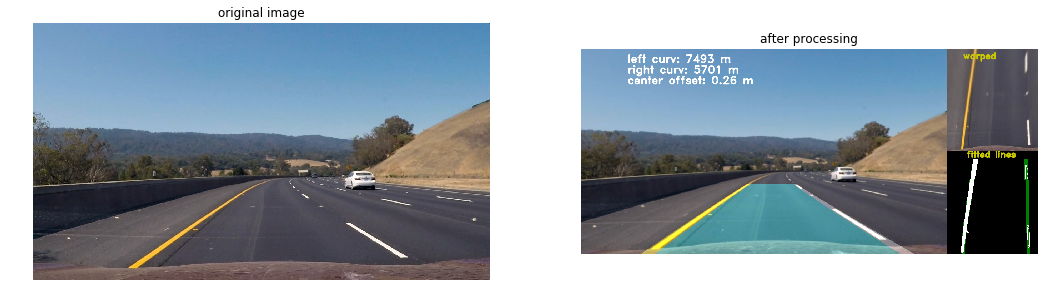

In [75]:
# we read an image
##interesting ones: 4
#6 : straight line
INDEX = 4

image = cv2.imread(test_images[INDEX])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#plt.imshow(image) 
#plt.axis('off');


p = Pipeline()
result = p.process(image)

plt.figure(figsize=(18,12))

plt.subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
plt.title('original image')

plt.subplot(1,2,2)
plt.imshow(result)
plt.title('after processing')
plt.axis('off');

In [76]:
! ls

README.md                  output_project_video.mp4
camera_cal                 project.ipynb
examples                   test_images
output_challenge_video.mp4 trapezoid.png
output_images              writeup.md


In [ ]:
this is a test
<video controls src="output_test_video.mp4" />